# Task 2: Risk Rating
## Problem Description
- Problem: there are too many clients in our customer database and heterogeneous, we would like
to automate this process to be as efficient and reliable as possible
- Ask: using predictive modelling classify all 1M customers into three risk buckets: **Low,
Medium and High**. As features, you must use KYC data and transactional data, your **target
variable is the risk rating provided**
- Diagram: ![task2_dia](https://drive.google.com/file/d/1Bzj2tn8QEObICYKvw7km2TfIMPKK-UIq/view?usp=sharing)

## Datasets
### Nodes Data
Description: main data source for this competition, contains KYC, Transactional data and Risk
Rating
- File name: UofT_nodes.csv -> df_origin -> **df_kyc**
- Number of Rows: 1M, one row per CUSTOMER_ID
- Number of Columns: 20 columns (1 target column); RISK = Target variable for Task 2

### Edges Data
Description: shows the connections between clients i.e. amount of money sent via EMT from
one customer (source) to another (target)
- File name: UofT_edges.csv
- Number of Rows: 466k

### Occupation Data
Description: lookup table that maps an occupation (code) to their risk level of being
involved in financial crimes
- File name: UofT_occupation_risk.csv
- Number of Rows: 841

## Exploratory Data Analysis
### Library

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
file_path = '/Users/zhuchenhao/Desktop/BigDataCompetition/UofT_nodes.csv'
df = pd.read_csv(file_path)
df.head()

,BIRTH_DT,CUST_ADD_DT,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,WIRES_CNT_OUT,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,NAME,GENDER,CUSTOMER_ID
0,1981-09-01,2007-07-05,89.0,1,1,0.0,2577.785,2.0,2851.663,7.0,70774.0,62.0,24244.0,35.0,Low,Low,low,"Young, Marie Mildren Coleman",Female,935382.0
1,1994-02-21,2019-05-19,89.0,1,1,0.0,3035.502,2.0,4805.997,15.0,282929.0,76.0,196439.0,152.0,Low,Low,low,Mark Stupar Lecy,Male,2305.0
2,1962-11-16,2011-08-02,89.0,1,1,0.0,1617.571,1.0,3482.809,11.0,7632.0,6.0,33598.0,20.0,Low,Low,low,Dean Glasper Wendel Reeves,Male,472403.0
3,1998-06-20,2001-08-15,89.0,1,1,0.0,3587.042,5.0,1940.943,8.0,149253.0,71.0,105896.0,238.0,Low,Low,low,"Hulsey, Linda Rauth",Female,227994.0
4,1942-01-24,2012-10-28,89.0,1,1,0.0,1725.524,2.0,13197.169,43.0,92318.0,96.0,187403.0,180.0,Low,Low,low,Carolyn Washington Roberts,Female,418265.0


In [3]:
print('--------------View Columns--------------')
print('Number of Columns:', len(df.columns))
print(df.columns.tolist())
print('--------------NULL & NaN Check--------------')
for i in range(len(df.columns)):
    col = df.columns[i]
    if df[col].isnull().values.any():
        print(col, 'contains %d NULL' % df[col].isnull().values.sum())
    if df[col].values.dtype != 'O':
        if np.isnan(df[col].values).any():
            print(col, 'contains %d NaN' % np.isnan(df[col].values).sum())

--------------View Columns--------------
Number of Columns: 20
['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'RES_CNTRY_CA', 'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RISK', 'NAME', 'GENDER', 'CUSTOMER_ID']
--------------NULL & NaN Check--------------
CUST_ADD_DT contains 4178 NULL
OCPTN_NM contains 6384 NULL
OCPTN_NM contains 6384 NaN
NAME contains 660 NULL
GENDER contains 628 NULL


In [4]:
df = df.dropna(how='any', axis=0)

## Machine Learning Models
### Library

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import urllib
from scipy.stats import chi2_contingency
plt.style.use('ggplot')
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, mean_squared_error,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
import seaborn as sb
from sklearn.metrics import make_scorer, confusion_matrix

In [65]:
# file_path = '/content/UofT_nodes.csv'
# df = pd.read_csv(file_path,  dtype=str)

In [6]:
# df

In [7]:
df.count().isnull().sum()

0

In [8]:
df['COUNTRY_RISK_INCOME'] = df['COUNTRY_RISK_INCOME'].astype('category').cat.codes

In [9]:
df['COUNTRY_RISK_RESIDENCY'] = df['COUNTRY_RISK_RESIDENCY'].astype('category').cat.codes
df['RISK'] = df['RISK'].replace(['low'], 0)
df['RISK'] = df['RISK'].replace(['medium'], 1)
df['RISK'] = df['RISK'].replace(['high'], 2)
df['GENDER'] = df['GENDER'].astype('category').cat.codes

In [10]:
df['COUNTRY_RISK_INCOME'].unique()
df['COUNTRY_RISK_RESIDENCY'].unique()
df['RISK'].unique()

array([0, 1, 2])

In [11]:
df['GENDER'].unique()

array([0, 1], dtype=int8)

In [12]:
# df

In [13]:
# df.info()

In [16]:
for i in range(2, 13):
    df.iloc[:, i] = df.iloc[:, i].astype(float)

In [17]:
df.dtypes

BIRTH_DT                   object
CUST_ADD_DT                object
OCPTN_NM                  float64
RES_CNTRY_CA              float64
CNTRY_OF_INCOME_CA        float64
PEP_FL                    float64
CASH_SUM_IN               float64
CASH_CNT_IN               float64
CASH_SUM_OUT              float64
CASH_CNT_OUT              float64
WIRES_SUM_IN              float64
WIRES_CNT_IN              float64
WIRES_SUM_OUT             float64
WIRES_CNT_OUT             float64
COUNTRY_RISK_INCOME          int8
COUNTRY_RISK_RESIDENCY       int8
RISK                        int64
NAME                       object
GENDER                       int8
CUSTOMER_ID               float64
dtype: object

# Creating some time variables

In [66]:
df['DayBirth'] = pd.to_datetime(df[ "BIRTH_DT"]).dt.day
df['MonthBirth'] = pd.to_datetime(df[ "BIRTH_DT"]).dt.month
df['YearBirth'] = pd.to_datetime(df[ "BIRTH_DT"]).dt.year

# convert the datetime columns to pandas datetime format
df['BIRTH_DT'] = pd.to_datetime(df['BIRTH_DT'])
df['CUST_ADD_DT'] = pd.to_datetime(df['CUST_ADD_DT'])

# calculate the difference in terms of years, months, and days
df['diff_years'] = (df['CUST_ADD_DT'] - df['BIRTH_DT']).dt.total_seconds() // (365 * 24 * 60 * 60) # years
df['diff_months'] = (df['CUST_ADD_DT'] - df['BIRTH_DT']).dt.total_seconds() // (30 * 24 * 60 * 60) # months
df['diff_days'] = (df['CUST_ADD_DT'] - df['BIRTH_DT']).dt.total_seconds() // (24 * 60 * 60) # days



In [69]:
# corr = df.corr()
# plt.figure(figsize=(20,20))
# ax = sns.heatmap(
#     corr, 
#     vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(20, 220, n=200),
#     square=True
# )
# ax.set_xticklabels(
#     ax.get_xticklabels(),
#     rotation=45,
#     horizontalalignment='right'
# );
# plt.show()

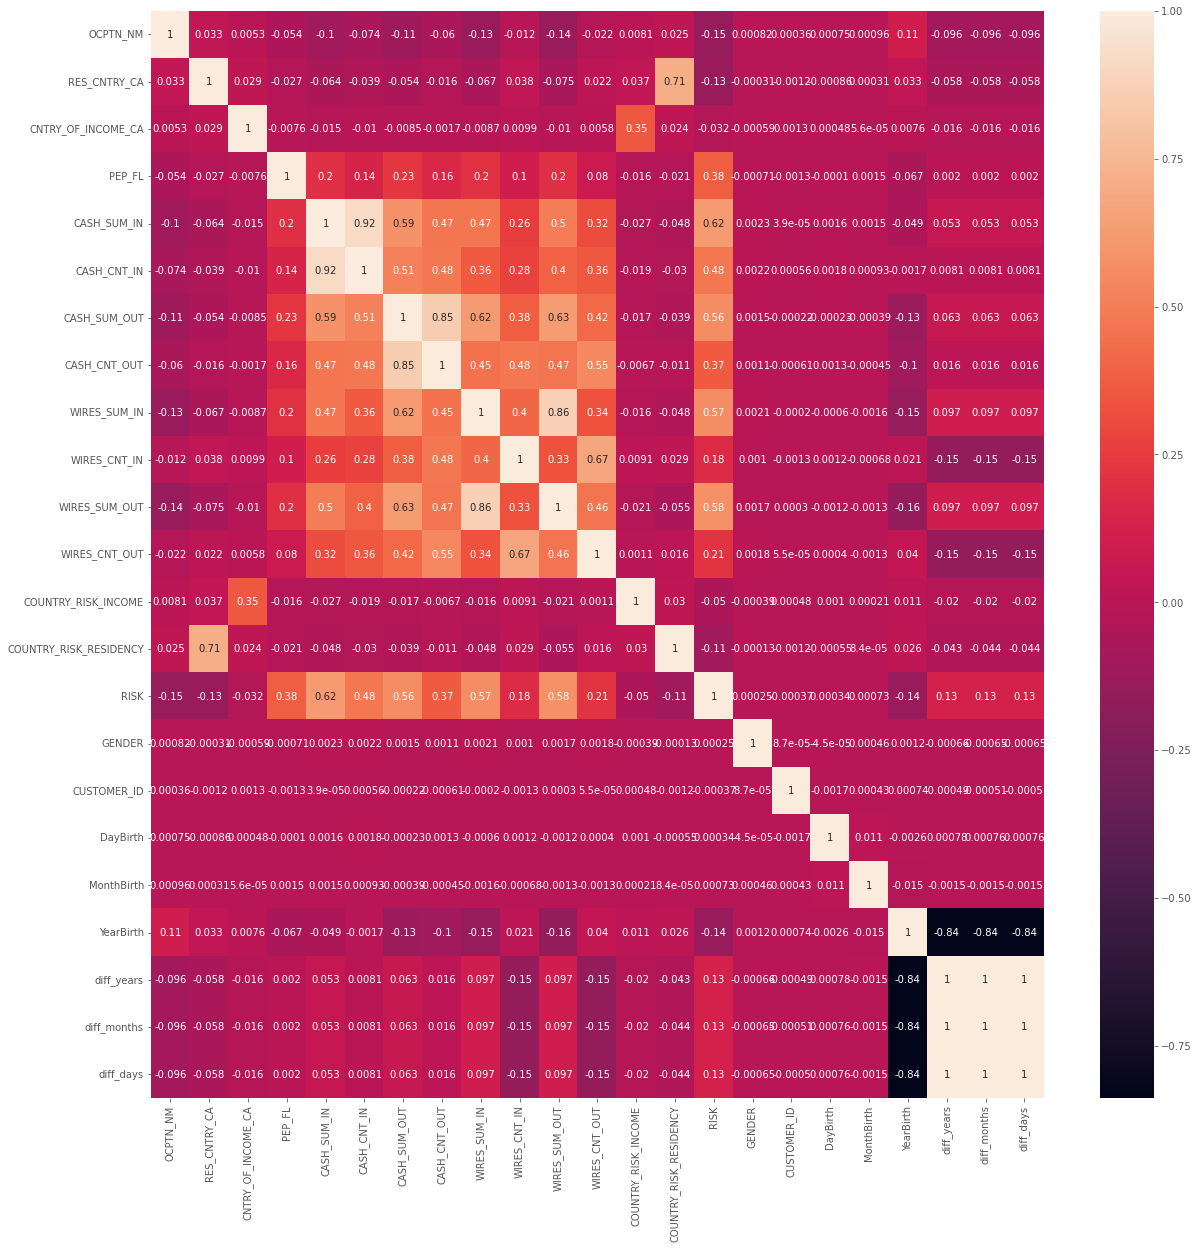

In [68]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

## Feature Selection

In [70]:
df.columns

Index(['BIRTH_DT', 'CUST_ADD_DT', 'OCPTN_NM', 'RES_CNTRY_CA',
       'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN',
       'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN',
       'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME',
       'COUNTRY_RISK_RESIDENCY', 'RISK', 'NAME', 'GENDER', 'CUSTOMER_ID',
       'DayBirth', 'MonthBirth', 'YearBirth', 'diff_years', 'diff_months',
       'diff_days'],
      dtype='object')

In [136]:
feature0 = ['OCPTN_NM', 'RES_CNTRY_CA',
       'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN',
       'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN',
       'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME',
       'COUNTRY_RISK_RESIDENCY', 'RISK', 'GENDER',
       'DayBirth', 'MonthBirth', 'YearBirth', 'diff_years', 'diff_months',
       'diff_days']
feature1 = ['OCPTN_NM', 'RES_CNTRY_CA',
       'CNTRY_OF_INCOME_CA', 'PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN',
       'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN',
       'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'COUNTRY_RISK_INCOME',
       'COUNTRY_RISK_RESIDENCY', 'GENDER',
       'DayBirth', 'MonthBirth', 'YearBirth', 'diff_years', 'diff_months',
       'diff_days']
feature = ['PEP_FL', 'CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 'WIRES_SUM_OUT']
# df_new = df[feature]
df = df[feature0]
df1 = df[feature1]
df.head()

,OCPTN_NM,RES_CNTRY_CA,CNTRY_OF_INCOME_CA,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,...,COUNTRY_RISK_INCOME,COUNTRY_RISK_RESIDENCY,RISK,GENDER,DayBirth,MonthBirth,YearBirth,diff_years,diff_months,diff_days
0,89.0,1.0,1.0,0.0,2577.785,2.0,2851.663,7.0,70774.0,62.0,...,1,1,0,0,1,9,1981,25.0,314.0,9438.0
1,89.0,1.0,1.0,0.0,3035.502,2.0,4805.997,15.0,282929.0,76.0,...,1,1,0,1,21,2,1994,25.0,307.0,9218.0
2,89.0,1.0,1.0,0.0,1617.571,1.0,3482.809,11.0,7632.0,6.0,...,1,1,0,1,16,11,1962,48.0,593.0,17791.0
3,89.0,1.0,1.0,0.0,3587.042,5.0,1940.943,8.0,149253.0,71.0,...,1,1,0,0,20,6,1998,3.0,38.0,1152.0
4,89.0,1.0,1.0,0.0,1725.524,2.0,13197.169,43.0,92318.0,96.0,...,1,1,0,0,24,1,1942,70.0,861.0,25845.0


In [90]:
selectM = df.corr().abs().sort_values('RISK', ascending=False)['RISK']
corr_col = selectM[(selectM > 0.1) & (selectM < 1)].index.tolist()

In [ ]:
# Only want the 

In [91]:
len(corr_col)

16

# Using highest 16 corrletion between features and target, also we want each feature to be independent to each other, for each indivudial feature, we select 10 feature with lowest sum of corrletion with other features.

In [126]:
temp0 = df1[corr_col].corr().abs()
cu = []
for i in temp0.columns :
    cu.append(temp0[i].sum())
temp1 = pd.DataFrame(cu, index = temp0.columns.tolist(), columns = ['Corrletion_Sum'])
feature = temp1.sort_values('Corrletion_Sum', ascending=True).head(10).index.tolist()

# Done for correlation check

In [137]:
df_new = df[feature]
df_new['RISK'] = df['RISK']
df_new

,PEP_FL,CASH_SUM_IN,CASH_CNT_IN,CASH_SUM_OUT,CASH_CNT_OUT,WIRES_SUM_IN,WIRES_CNT_IN,WIRES_SUM_OUT,RISK
0,0.0,2577.785,2.0,2851.663,7.0,70774.0,62.0,24244.0,0
1,0.0,3035.502,2.0,4805.997,15.0,282929.0,76.0,196439.0,0
2,0.0,1617.571,1.0,3482.809,11.0,7632.0,6.0,33598.0,0
3,0.0,3587.042,5.0,1940.943,8.0,149253.0,71.0,105896.0,0
4,0.0,1725.524,2.0,13197.169,43.0,92318.0,96.0,187403.0,0
...,...,...,...,...,...,...,...,...,...
999995,0.0,18945.108,10.0,32210.000,21.0,1186467.0,25.0,2550098.0,2
999996,0.0,5775.601,7.0,5015.741,15.0,244504.0,53.0,417992.0,0
999997,0.0,2351.255,2.0,15997.000,19.0,3024271.0,68.0,948981.0,2
999998,0.0,27312.613,8.0,3399.000,5.0,943477.0,9.0,376429.0,2


In [138]:
train = df_new.sample(frac=0.7)
test = df_new.drop(train.index)
scaler = StandardScaler()

# Resampling + RF

In [139]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [140]:
X = train[feature]
y = train['RISK']

print("Original class distribution:")
print(pd.Series(y).value_counts())

Original class distribution:
0    415023
1    242568
2     34583
Name: RISK, dtype: int64


In [141]:
ros = RandomOverSampler(random_state=42)
X_resampled_ros, y_resampled_ros = ros.fit_resample(X, y)
print("\nRandom oversampling class distribution:")
print(pd.Series(y_resampled_ros).value_counts())


Random oversampling class distribution:
1    415023
0    415023
2    415023
Name: RISK, dtype: int64


In [142]:
rus = RandomUnderSampler(random_state=42)
X_resampled_rus, y_resampled_rus = rus.fit_resample(X, y)
print("\nRandom undersampling class distribution:")
print(pd.Series(y_resampled_rus).value_counts())


Random undersampling class distribution:
0    34583
1    34583
2    34583
Name: RISK, dtype: int64


In [32]:
# X_resampled_rus

In [123]:
smote = SMOTE(random_state=42)
X_resampled_smote, y_resampled_smote = smote.fit_resample(X, y)
print("\nSMOTE class distribution:")
print(pd.Series(y_resampled_smote).value_counts())


smoteenn = SMOTEENN(random_state=42)
X_resampled_smoteenn, y_resampled_smoteenn = smoteenn.fit_resample(X, y)
print("\nSMOTEENN class distribution:")
print(pd.Series(y_resampled_smoteenn).value_counts())


SMOTE class distribution:
0    415358
1    415358
2    415358
Name: RISK, dtype: int64

SMOTEENN class distribution:
2    340492
1    184248
0    167292
Name: RISK, dtype: int64


In [143]:
def train_evaluate_rf(X, y, title=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
#     scaler.fit(X_train)
#     X_train_scaled = scaler.transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"{title}\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
    print(classification_report(y_test, y_pred))

train_evaluate_rf(X, y, title="Original Data")
train_evaluate_rf(X_resampled_ros, y_resampled_ros, title="Random Oversampling")
train_evaluate_rf(X_resampled_rus, y_resampled_rus, title="Random Undersampling")
# train_evaluate_rf(X_resampled_smote, y_resampled_smote, title="SMOTE")
# train_evaluate_rf(X_resampled_smoteenn, y_resampled_smoteenn, title="SMOTEENN")

Original Data
Accuracy: 0.9532
F1-Score: 0.9447

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    124285
           1       0.90      0.97      0.94     72883
           2       0.60      0.25      0.35     10485

    accuracy                           0.95    207653
   macro avg       0.83      0.74      0.76    207653
weighted avg       0.94      0.95      0.94    207653

Random Oversampling
Accuracy: 0.9909
F1-Score: 0.9909

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    124648
           1       1.00      0.97      0.99    124386
           2       0.97      1.00      0.99    124487

    accuracy                           0.99    373521
   macro avg       0.99      0.99      0.99    373521
weighted avg       0.99      0.99      0.99    373521

Random Undersampling
Accuracy: 0.8875
F1-Score: 0.8869

              precision    recall  f1-score   support

           0       0.99

In [115]:
X2 = test[feature]
X2_test_scaled = scaler.transform(X2)
y2 = test['RISK']

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_ros, y_resampled_ros, test_size=0.1, random_state=42)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

X2 = test[feature]
# X2_test_scaled = scaler.transform(X2)
y2 = test['RISK']
y_pred = clf.predict(X2)#X_test
accuracy = accuracy_score(y2, y_pred)#y_test
f1 = f1_score(y2, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
print(classification_report(y2, y_pred))


Accuracy: 0.9526
F1-Score: 0.9491

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    178181
           1       0.92      0.95      0.93    103585
           2       0.54      0.39      0.45     14880

    accuracy                           0.95    296646
   macro avg       0.82      0.78      0.80    296646
weighted avg       0.95      0.95      0.95    296646



In [ ]:
# y_pred = clf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')

# print(f"\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
# print(classification_report(y_test, y_pred))

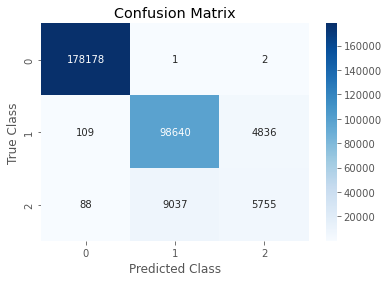

In [145]:
# Plot confusion matrix
cm = confusion_matrix(y2, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

# Resampling + Log

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 0.8874
F1-Score: 0.8869

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    126135
           1       0.88      0.78      0.82    125874
           2       0.80      0.89      0.84    126144

    accuracy                           0.89    378153
   macro avg       0.89      0.89      0.89    378153
weighted avg       0.89      0.89      0.89    378153



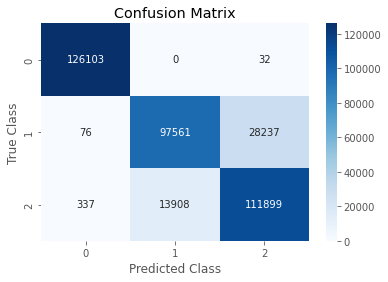

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
clf = LogisticRegression(multi_class='auto', solver='lbfgs')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

# Resampling + DT


Accuracy: 0.8913
F1-Score: 0.8917

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    126135
           1       0.86      0.83      0.84    125874
           2       0.82      0.87      0.84    126144

    accuracy                           0.89    378153
   macro avg       0.89      0.89      0.89    378153
weighted avg       0.89      0.89      0.89    378153



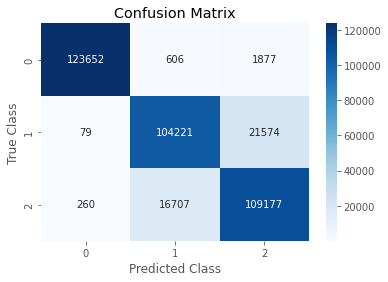

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_smote, y_resampled_smote, test_size=0.3, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nAccuracy: {accuracy:.4f}\nF1-Score: {f1:.4f}\n")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Add labels to the plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()
plt.show()

# Log

In [ ]:
X = train[feature]
y = train['RISK']

kf = KFold(n_splits=10)
results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)    
    
    model = LogisticRegression(multi_class='auto', solver='lbfgs')
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    results.append(accuracy)

avg_accuracy = np.mean(results)
print('Average accuracy:', avg_accuracy)


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Average accuracy: 0.9505542857142857


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
avg_accuracy = np.mean(results)
print('Average accuracy:', avg_accuracy)

Average accuracy: 0.9505542857142857


In [ ]:
best_model = LogisticRegression(multi_class='auto', solver='lbfgs')
scaler = StandardScaler()

X_train = train[feature]
y_train = train['RISK']

X_test = test[feature]
y_test = test['RISK']


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
    
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9501866666666666
precision: 0.9386366721457444
recall: 0.9501866666666666


# RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = train[feature]
y = train['RISK']

kf = KFold(n_splits=10)
results = []

X = scaler.fit_transform(X)
clf = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the model to the data
clf.fit(X, y)

# Make predictions using the trained model
y_pred = clf.predict(X)

In [ ]:
X_train = train[feature]
y_train = train['RISK']

X_test = test[feature]
y_test = test['RISK']


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

In [ ]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.95371
precision: 0.9450126495046363
recall: 0.95371


# Decision Tree

In [ ]:
X = train[feature]
y = train['RISK']

kf = KFold(n_splits=10)
results = []

X = scaler.fit_transform(X)
clf = DecisionTreeClassifier()

# Fit the model to the data
clf.fit(X, y)

X_train = train[feature]
y_train = train['RISK']

X_test = test[feature]
y_test = test['RISK']


X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average = 'weighted')
recall = recall_score(y_test, y_pred, average = 'weighted')

In [ ]:
print('accuracy:', accuracy)
print('precision:', precision)
print('recall:', recall)

accuracy: 0.9365266666666666
precision: 0.9375031332257667
recall: 0.9365266666666666
